In [2]:
import io
from PIL import Image
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import json
import torch.utils.data as tdata
from tqdm import tqdm
from torch import optim 
import torch.nn as nn

from transformers.models.detr.feature_extraction_detr import rgb_to_id
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [3]:
seed_value = 7
torch.manual_seed(seed_value)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)

In [4]:
device= torch.device("cuda:0")
device

device(type='cuda', index=0)

In [5]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")
model = AutoModelForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd").to(device)

In [6]:
from datasets import load_dataset

dataset = load_dataset("Francesco/sign-language-sokdr")

KeyboardInterrupt: 

In [ ]:
SIZE=640

In [ ]:
class Dataset(tdata.Dataset):
    def __init__(self,dataset,processor):
        self.processor=processor

        self.image=[]
        self.type=[]
        self.bbox=[]
        for id in range(len(dataset['image'])):
            if dataset['objects'][id]['category'][0] <25:
                self.image.append(dataset['image'][id])
                self.type.append(dataset['objects'][id]['category'][0]-1)
                box=np.array(dataset['objects'][id]['bbox'][0])
                box/=SIZE
                self.bbox.append(box)
        self.len=len(self.image)
    
    def __getitem__(self, id):
        return  torch.from_numpy(np.array(self.image[id])).to(device),torch.from_numpy(self.bbox[id]).type(dtype=torch.float).to(device)
    

    def __len__(self):
        return self.len
    


In [ ]:
train_set=Dataset(dataset['train'][0:504],processor=processor)
valid_set=Dataset(dataset['validation'][0:72],processor=processor)

train_data=tdata.DataLoader(train_set,batch_size=50)

valid_data=tdata.DataLoader(valid_set,batch_size=10)


In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, output, target):
        py=[]
        for d in output:
            if len(d['boxes']) >0:
                py.append(d['boxes'][0])
            else:
                py.append(torch.full(size=(1,4),fill_value= 0,requires_grad=True,dtype=torch.float32)[0].to(device))
        # print(torch.stack(py))
        # print(target)
        # print()
        # print()
        # print()
        # print()
        return self.mse_loss(torch.stack(py),target)
    

In [ ]:
optimize=optim.Adam(model.parameters(),lr=0.00001)

criterion=CustomLoss()
#torchvision.ops.complete_box_iou_loss


In [ ]:
EPOCH=[]
TLOSS=[]
VLOSS=[]

for epoch in tqdm(range(2)):
    model.train()
    tloss=0
    for x,y in train_data:
        optimize.zero_grad()
        input=processor(images=x, return_tensors="pt")
        py=model(input['pixel_values'].to(device))
        py=processor.post_process_object_detection(py)
        loss=criterion(py,y)
        loss.backward()
        optimize.step()
        tloss+=loss.item()
    TLOSS.append(tloss)

    model.eval()
    tloss=0
    for x,y in valid_data:
        input=processor(images=x, return_tensors="pt")
        py=model(input['pixel_values'].to(device))
        py=processor.post_process_object_detection(py)
        loss=criterion(py,y)
        tloss+=loss.item()
    VLOSS.append(tloss)

    EPOCH.append(epoch)
    

  0%|          | 0/2 [00:30<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 

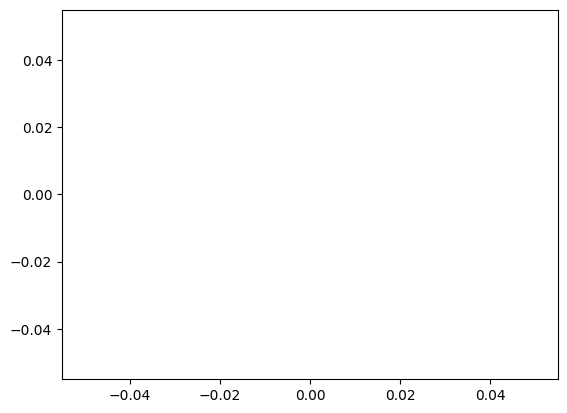

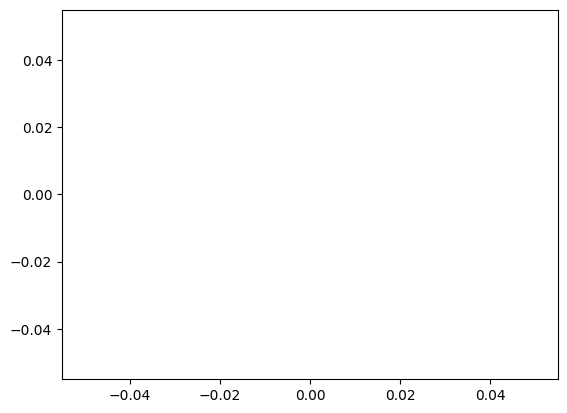

In [ ]:
plt.plot(EPOCH,TLOSS)
plt.show()
plt.plot(EPOCH,VLOSS)
plt.show()